# Data Preprocessing
We need to filter and feature-select data to provide consistent inputs to dimensionality reduction methods.

In [15]:
import sys
sys.path.append('../')
from fcc_DRs import *
%matplotlib inline

---
To benchmark dimensionality reduction techniques, we are using two datasets:
* From [__Macosko, *et al* (2015)__](https://www.ncbi.nlm.nih.gov/pubmed/26000488), the mouse retina scRNA-seq data generated using DropSeq: [GSM1626793](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM1626793)
* From [__Herring, *et al* (2018)__](https://www.ncbi.nlm.nih.gov/pubmed/29153838), the WT mouse colon scRNA-seq data generated using inDrops: [GSM2743164](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM2743164)  
  
The first set should be highly __discrete__, containing highly separable cell populations, where the latter should be __continuous__, representing a continuum of branching cell states in the gut epithelium.  
  
In this notebook, we will read in the counts for each of these datasets, _select gene features_ to limit input size to dimensionality reduction methods, and _downsample to a common cell number_ for ease of comparison.

---
#### 0.0 read in discrete dataset and preprocess
* cell normalization and _arcsinh-transformation_
* 100-component _PCA_
* _t-SNE_ with perplexity 30

In [2]:
retina = RNA_counts.from_file('../inputs/GSM1626793_P14Retina_1.digital_expression.csv.gz', cells_axis=1, labels=[0,0])

In [3]:
# see how many cells and genes are present in whole counts matrix
retina.data.shape

(6600, 20478)

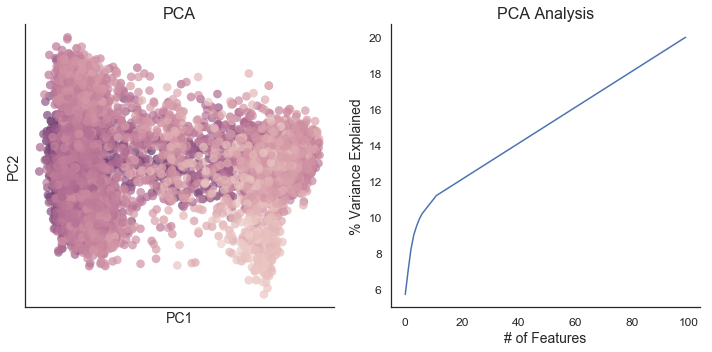

In [4]:
# arcsinh-normalize fractional counts for all 20k+ genes, and perform 100 component PCA
retina_PCA100 = fcc_PCA(retina.arcsinh_norm(norm='l1'), n_components=100)
retina_PCA100.plot_PCA()

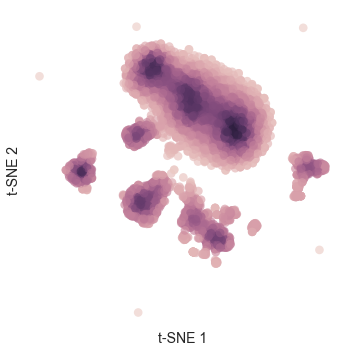

CPU times: user 1min 3s, sys: 1.27 s, total: 1min 4s
Wall time: 1min 4s


In [9]:
%%time 
# now perform standard t-SNE (perplexity 30) and show results
retina_tSNE = fcc_tSNE(retina_PCA100.results, perplexity=30, seed=18)
retina_tSNE.plot()

---
#### 0.1 assign clusters
* density-peak clustering of whole-dataset t-SNE

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x123b5c7b8>)

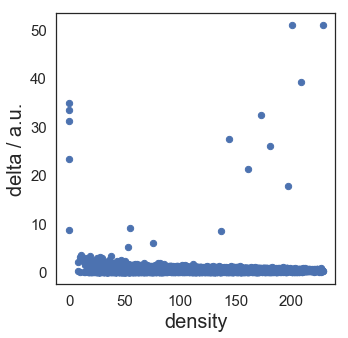

In [10]:
# show potential density-peak cluster centers
retina_tSNE.clu.draw_decision_graph()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x123e34cf8>)

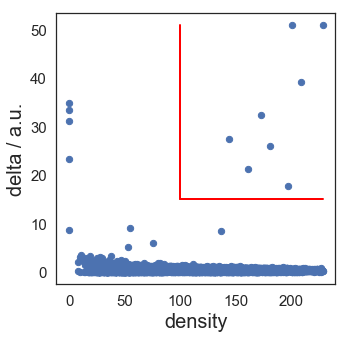

In [18]:
# assign cluster center cutoffs and show decision graph again
retina_tSNE.clu.assign(100,15)
retina_tSNE.clu.draw_decision_graph(min_delta=retina_tSNE.clu.min_delta, 
                                    min_density=retina_tSNE.clu.min_density)

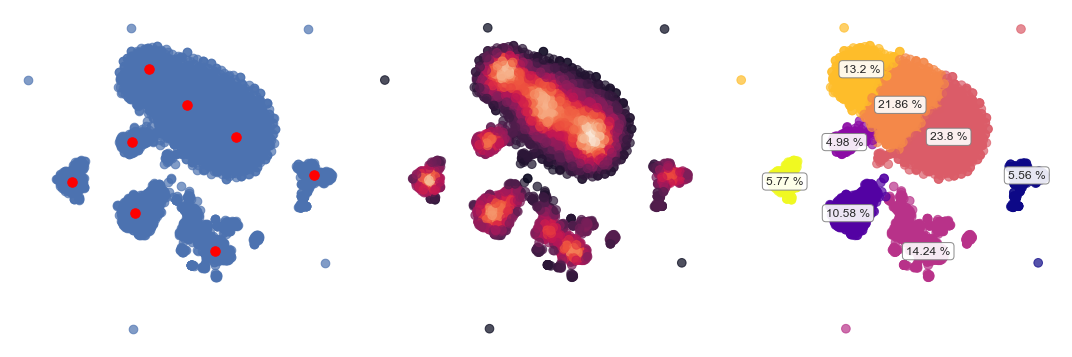

In [19]:
retina_tSNE.plot_clusters() # visualize clustering

In [20]:
retina_tSNE.cluster_counts()

367 cells in cluster 0 (5.561 %)

698 cells in cluster 1 (10.576 %)

329 cells in cluster 2 (4.985 %)

940 cells in cluster 3 (14.242 %)

1571 cells in cluster 4 (23.803 %)

1443 cells in cluster 5 (21.864 %)

871 cells in cluster 6 (13.197 %)

381 cells in cluster 7 (5.773 %)



In [21]:
print('Silhouette Score: {}\n'.format(retina_tSNE.silhouette_score()))

Silhouette Score: 0.5126386284828186



---
#### 0.2 filter genes and cells to manageable size
* _select variable genes_ to reduce dimension
* _downsample cells_ for future processing, maintaining cluster proportions

In [22]:
# select 500 most variable genes
retina_varselect = RNA_counts.var_select(retina, n_features=500) 

In [27]:
# choose 1600 cells with proportional representation from clusters above
retina_0 = RNA_counts.downsample_proportional(retina_varselect, retina_tSNE.clu.membership, n_cells=1600, seed=18)

In [33]:
# ensure there are no genes or cells with zero counts for the whole resulting matrix
print('minimum counts per cell: {}\nminimum counts per gene: {}'.format(retina_0.data.sum(axis=1).min(), retina_0.data.sum(axis=0).min()))

minimum counts per cell: 105
minimum counts per gene: 75


Now, we can re-visualize as before to make sure we have a representative subset of the data:

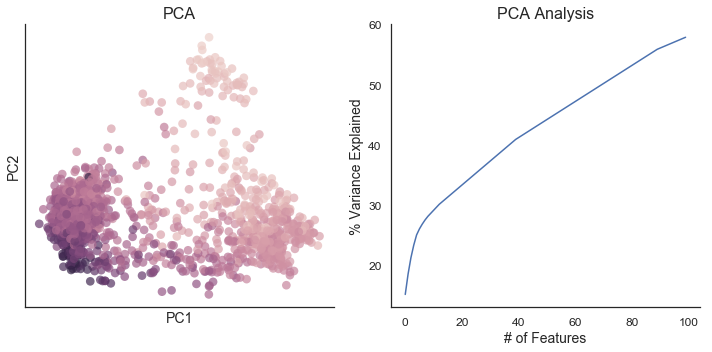

CPU times: user 1.2 s, sys: 109 ms, total: 1.31 s
Wall time: 832 ms


In [39]:
%%time
retina_0_PCA100 = fcc_PCA(matrix=retina_0.arcsinh_norm(), n_components=100)
retina_0_PCA100.plot_PCA()

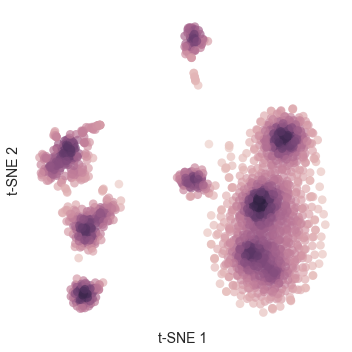

CPU times: user 9.71 s, sys: 75.4 ms, total: 9.79 s
Wall time: 9.66 s


In [40]:
%%time
retina_0_tSNE = fcc_tSNE(retina_0_PCA100.results, perplexity=30, seed=18)
retina_0_tSNE.plot()

---
#### 0.3 write results to file

In [19]:
retina_0.data.to_csv('../inputs/GSM1626793_P14Retina_1.processed.tsv', sep='\t', header=True, index=True)

In [21]:
retina_0.data.to_csv('../inputs/GSM1626793_P14Retina_1.processed.norowlabels.tsv', sep='\t', header=True, index=False)

---
#### 1.0 read in continuous dataset and preprocess
* cell normalization and _arcsinh-transformation_
* 100-component _PCA_
* _t-SNE_ with perplexity 30

In [47]:
colon = RNA_counts.from_file(datafile='../inputs/GSM2743164_rep1_colon_rnaseq.csv.gz', cells_axis=1, labels=[0,0])

In [48]:
# see how many cells and genes are present in whole counts matrix
colon.data.shape

(1738, 25504)

This cell number is already what we want.  Let's just select the 500 most variable genes and visualize the dataset.

---
#### 1.1 filter genes to manageable size
* _select variable genes_ to reduce dimension

In [49]:
# select 500 most variable genes
colon_0 = RNA_counts.var_select(colon, n_features=500) 

In [52]:
# ensure there are no genes or cells with zero counts for the whole resulting matrix
print('minimum counts per cell: {}\nminimum counts per gene: {}'.format(colon_0.data.sum(axis=1).min(), colon_0.data.sum(axis=0).min()))

minimum counts per cell: 307
minimum counts per gene: 249


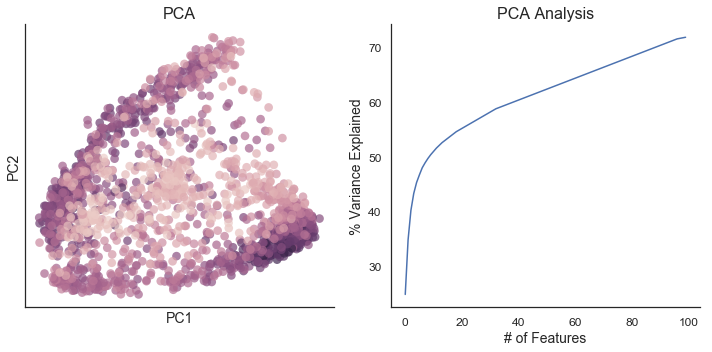

CPU times: user 1.33 s, sys: 143 ms, total: 1.47 s
Wall time: 1.03 s


In [50]:
%%time
colon_0_PCA100 = fcc_PCA(matrix=colon_0.arcsinh_norm(), n_components=100)
colon_0_PCA100.plot_PCA()

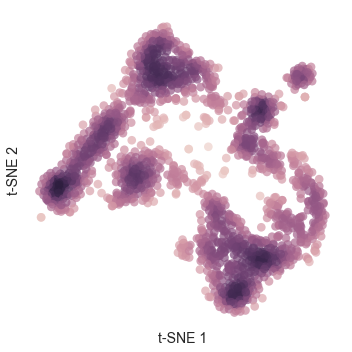

CPU times: user 10.4 s, sys: 175 ms, total: 10.6 s
Wall time: 10.4 s


In [51]:
%%time
colon_0_tSNE = fcc_tSNE(colon_0_PCA100.results, perplexity=30, seed=18)
colon_0_tSNE.plot()

---
#### 1.2 write results to file

In [24]:
colon_0.data.to_csv('../inputs/GSM2743164_rep1_colon_rnaseq.processed.tsv', sep='\t', header=True, index=True)

In [25]:
colon_0.data.to_csv('../inputs/GSM2743164_rep1_colon_rnaseq.processed.norowlabels.tsv', sep='\t', header=True, index=False)